# Bagging with Random Forests

## Bagging ensembles
Ensemble models aggregate the results of multiple machine models, making them superior to individual models because they are less prone to error. Ensemble methods are generally classified into two types. The first type combines different machine learning models as chosen by the user. The second type, such as XGBoost and random forests, combines many versions of the same model. The overall accuracy of ensemble methods tend to be higher than individual models, but they are more computationally expensive and take longer to train.

Bootstrap aggregation, or bagging, is a method of combining multiple machine learning models to reduce variance. Bagging is a special case of the model averaging approach. In bagging, the same machine learning algorithm is trained many times using different subsets (with replacement) sampled from the training data. The final output is averaged across the predictions of all of the sub-models. Bagging can be used to reduce the variance of a model. It also reduces the chance of overfitting, since it is not as sensitive to small changes in the training data. Random forests aggregate the predictions of bootstrapped decision trees.

## Exploring random forests

In [38]:
# Use a random forest classifier to predict whether a user makes more or less than $50,000 USD using census data.
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [39]:
df_census = pd.read_csv('census_cleaned.csv')
X_census = df_census.iloc[:, :-1]
y_census = df_census.iloc[:, -1]

In [40]:
# Initialize a Random Forest classifier with 10 estimators
rf = RandomForestClassifier(n_estimators=10, random_state=2, n_jobs=-1)
scores = cross_val_score(rf, X_census, y_census, cv=5)

In [41]:
print('Accuracy:', np.round(scores, 3))
print('Accuracy mean: %0.3f' % (scores.mean()))

Accuracy: [0.851 0.844 0.851 0.852 0.851]
Accuracy mean: 0.850


The bagging method described in the previous section probably explains why the random forest performs better than the decision tree in the previous chapter. (86% vs. 81%) The bootstrapped trees increase the diversity of the training set and then aggregated. Random forests also work with regression.

In [42]:
df_bikes = pd.read_csv('bike_rentals_cleaned.csv')
df_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


In [43]:
X_bikes = df_bikes.iloc[:, :-1]
y_bikes = df_bikes.iloc[:, -1]

In [44]:
# Import the regressor and initialize it with the same default hyperparameters
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10, random_state=2, n_jobs=-1)

# Use cross_val_score to calculate the MSE for 10-fold CV
scores = cross_val_score(rf, X_bikes, y_bikes, scoring='neg_mean_squared_error', cv=10)
                         
# Find and display the RMSE
rmse = np.sqrt(-scores)
print('RMSE:', np.round(rmse, 3))
print('RMSE mean: %0.3f' % (rmse.mean()))

RMSE: [ 801.486  579.987  551.347  846.698  895.05  1097.522  893.738  809.284
  833.488 2145.046]
RMSE mean: 945.365


## Random forest hyperparameters
`oob_score` is a boolean that tells the random forest whether to use out-of-bag samples to estimate the R^2 on unseen data. 

In [45]:
# Initialize a Random Forest classifier with 10 estimators and oob_score=True
# 10 is probably not enough estimators to maximize accuracy, but oob_score=True is a good way to see how well the model is doing
rf = RandomForestClassifier(n_estimators=10, random_state=2, n_jobs=-1, oob_score=True)
rf.fit(X_census, y_census)
rf.oob_score_

0.8343109855348423

In [46]:
# Let's look at a larger number of estimators
rf = RandomForestClassifier(n_estimators=50, random_state=2, n_jobs=-1, oob_score=True)
rf.fit(X_census, y_census)
rf.oob_score_

0.8518780135745216

In [47]:
# And even more estimators
rf = RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1, oob_score=True)
rf.fit(X_census, y_census)
rf.oob_score_

0.8551334418476091

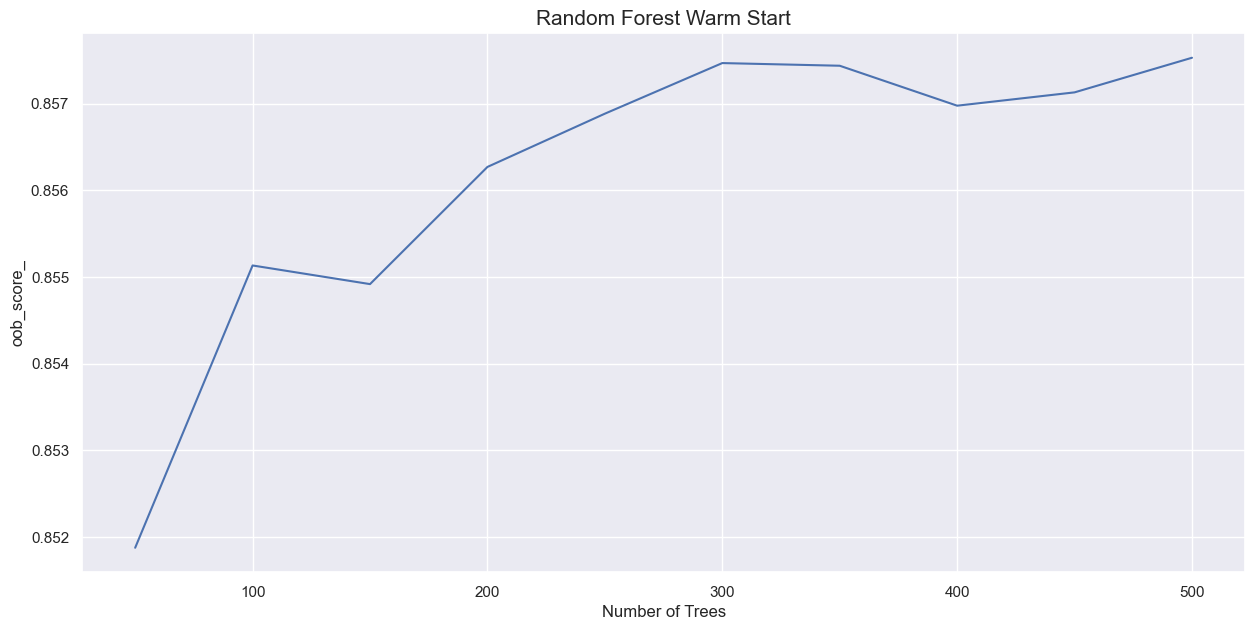

In [48]:
# warm_start allows us to add more trees without starting over from scratch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Initialize an empty set of scores and a random forest classifier with 50 estimators
oob_scores = []
rf = RandomForestClassifier(n_estimators=50, random_state=2, n_jobs=-1, warm_start=True, oob_score=True)

# Fit rf and append the oob_score to oob_scores
rf.fit(X_census, y_census)
oob_scores.append(rf.oob_score_)

# Prepare a list of estimators that contains the number of trees starting with 50
est = 50
estimators = [est]

for i in range(9):
    est += 50
    estimators.append(est)
    rf.set_params(n_estimators=est)
    rf.fit(X_census, y_census)
    oob_scores.append(rf.oob_score_)

# Plot the estimators and oob_scores
plt.figure(figsize=(15,7))
plt.plot(estimators, oob_scores)
plt.xlabel('Number of Trees')
plt.ylabel('oob_score_')
plt.title('Random Forest Warm Start', fontsize=15)
plt.savefig('Random_Forest_Warm_Start', dpi=325)
plt.show()

## Pushing random forest boundaries: case study
We previously implemented a random forest regressor with CV to obtain an RMSE of 945. The goal is to modify the random forest to obtain the lowest error score possible.

In [49]:
# Prepare the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bikes, y_bikes, test_size=0.3, random_state=2)

In [50]:
# Initialize a Random Forest regressor with 50 estimators
rf = RandomForestRegressor(n_estimators=50, warm_start=True, random_state=2, n_jobs=-1)

# Score the model using cross_val_score
score = cross_val_score(rf, X_bikes, y_bikes, scoring='neg_mean_squared_error', cv=10)

# Find the RMSE
rmse = np.sqrt(-score)

# Print the RMSE and RMSE averages
print('RMSE:', np.round(rmse, 3))
print('RMSE mean: %0.3f' % (rmse.mean()))

RMSE: [ 836.482  541.898  533.086  812.782  894.877  881.117  794.103  828.968
  772.517 2128.148]
RMSE mean: 902.398


In [51]:
# Fine-tune the hyperparameters using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
def randomized_search_reg(params, runs=16, reg=RandomForestRegressor(random_state=2, n_jobs=-1)):
    rand_reg = RandomizedSearchCV(reg, params, n_iter=runs, scoring='neg_mean_squared_error', n_jobs=-1, random_state=2, cv=10)
    rand_reg.fit(X_train, y_train)
    best_model = rand_reg.best_estimator_
    best_params = rand_reg.best_params_
    print('Best Parameters:', best_params)
    best_score = np.sqrt(-rand_reg.best_score_)
    print('Best Score:', np.round(best_score, 3))
    y_pred = best_model.predict(X_test)
    from sklearn.metrics import mean_squared_error as MSE
    rmse_test = MSE(y_test, y_pred) ** 0.5
    print('Test set score: {:.3f}'.format(rmse_test))

In [52]:
randomized_search_reg(params={'min_weight_fraction_leaf':[0.0,
0.0025, 0.005, 0.0075, 0.01, 0.05],'min_samples_split':[2,
0.01, 0.02, 0.03, 0.04, 0.06, 0.08, 0.1],'min_samples_leaf':[1,2,4,6,8,10,20,30],'min_impurity_decrease':[0.0, 0.01,
0.05, 0.10, 0.15, 0.2],'max_leaf_nodes':[10, 15, 20, 25, 30,
35, 40, 45, 50, None], 'max_features':['auto', 0.8, 0.7, 0.6,
0.5, 0.4],'max_depth':[None,2,4,6,8,10,20]})

Best Parameters: {'min_weight_fraction_leaf': 0.0, 'min_samples_split': 0.03, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.05, 'max_leaf_nodes': 25, 'max_features': 0.7, 'max_depth': None}
Best Score: 767.55
Test set score: 680.956


In [53]:
# Major improvement. Let's try again by narrowing the range.
randomized_search_reg(
    params={
        "min_samples_leaf": [1, 2, 4, 6, 8, 10, 20, 30],
        "min_impurity_decrease": [0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
        "max_features": ["auto", 0.8, 0.7, 0.6, 0.5, 0.4],
        "max_depth": [None, 2, 4, 6, 8, 10, 20],
    }
)

Best Parameters: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.1, 'max_features': 0.6, 'max_depth': 10}
Best Score: 691.015
Test set score: 627.700


In [54]:
# Increase the number of runs and give more options for max_depth
randomized_search_reg(
    params={
        "min_samples_leaf": [1, 2, 4, 6, 8, 10, 20, 30],
        "min_impurity_decrease": [0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
        "max_features": ["auto", 0.8, 0.7, 0.6, 0.5, 0.4],
        "max_depth": [None, 4, 6, 8, 10, 12, 15, 20]
    },
    runs=20,
)

Best Parameters: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.1, 'max_features': 0.6, 'max_depth': 12}
Best Score: 691.427
Test set score: 609.638


In [55]:
# The score keeps improving. Narrow the ranges further.
randomized_search_reg(
    params={
        'min_samples_leaf':[1, 2, 3, 4, 5, 6],
        'min_impurity_decrease':[0.0, 0.01, 0.05, 0.08, 0.10, 0.12, 0.15], 
        'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4],
        'max_depth':[None,8,10,12,14,16,18,20]})

Best Parameters: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.05, 'max_features': 0.7, 'max_depth': 18}
Best Score: 694.695
Test set score: 626.058


In [56]:
# Increase the number of runs and estimators
randomized_search_reg(
    params={
        'min_samples_leaf':[1,2,3,4,5,6],
        'min_impurity_decrease':[0.0, 0.01, 0.05, 0.08, 0.10, 0.12,0.15], 
        'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4],
        'max_depth':[None,8,10,12,14,16,18,20],
        'n_estimators':[100]},
    runs=20)

Best Parameters: {'n_estimators': 100, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.05, 'max_features': 0.7, 'max_depth': 18}
Best Score: 694.695
Test set score: 626.058


In [57]:
# Put the best model in cross_val_score to see how the result compares with the original
rf = RandomForestRegressor(
    min_samples_leaf=1,
    min_impurity_decrease=0.1,
    max_features=0.6,
    max_depth=12,
    n_estimators=100,
    random_state=2,
    n_jobs=-1,
)

scores = cross_val_score(rf, X_bikes, y_bikes, scoring='neg_mean_squared_error', cv=10)
rmse = np.sqrt(-scores)
print('RMSE:', np.round(rmse, 3))
print('RMSE mean: %0.3f' % (rmse.mean()))

RMSE: [ 818.354  514.173  547.392  814.059  769.54   730.025  831.376  794.634
  756.83  1595.237]
RMSE mean: 817.162


In [63]:
df_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


In [64]:
# The score is better than 903, but much worse than 609. What's wrong?
# The last split in cross_val_score is particularly bad. Maybe shuffling the data will work.
from sklearn.utils import shuffle
df_shuffle_bikes = shuffle(df_bikes, random_state=2)
df_shuffle_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
671,672,4.0,1.0,11.0,0.0,5.0,1.0,1,0.355000,0.356042,0.522083,0.266175,5847
199,200,3.0,0.0,7.0,0.0,2.0,1.0,1,0.776667,0.747479,0.650417,0.130600,4541
77,78,1.0,0.0,3.0,0.0,6.0,0.0,1,0.472500,0.466525,0.379167,0.368167,3117
225,226,3.0,0.0,8.0,0.0,0.0,0.0,2,0.676667,0.624388,0.817500,0.222633,3820
37,38,1.0,0.0,2.0,0.0,1.0,1.0,1,0.271667,0.303658,0.738333,0.045408,1712


In [65]:
X_shuffle_bikes = df_shuffle_bikes.iloc[:, :-1]
y_shuffle_bikes = df_shuffle_bikes.iloc[:, -1]

In [67]:
rf = RandomForestRegressor(
    n_estimators=100,
    min_impurity_decrease=0.1,
    max_features=0.6,
    max_depth=12,
    n_jobs=-1,
    random_state=2,
)

cross_val_score(
    rf, X_shuffle_bikes, y_shuffle_bikes, scoring="neg_mean_squared_error", cv=10
)
rmse = np.sqrt(-scores)
print("RMSE:", np.round(rmse, 3))
print("RMSE mean: %0.3f" % (rmse.mean()))

RMSE: [630.093 686.673 468.159 526.676 593.033 724.575 774.402 672.63  760.253
 616.797]
RMSE mean: 645.329
